In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import resample_poly, iirnotch, filtfilt, welch
import os
import random

fs_old = 1000
fs_new = 200
bin_sec = 2
bin_len = fs_new * bin_sec 


In [2]:
import scipy.io as sio

mat = sio.loadmat("George_ECoG128\Session1\ECoG_ch1.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'ECoGData_ch1'])


In [4]:
def load_session(folder):
    signals = []
    for ch in range(1, 129):
        mat = sio.loadmat(os.path.join(folder, f"ECoG_ch{ch}.mat"))
        keys = [k for k in mat.keys() if not k.startswith('__')]
        sig = mat[keys[0]].squeeze()
        signals.append(sig)
    return np.vstack(signals)  # (128, T)

In [ ]:
def preprocess(data):
    # downsampling
    data_ds = resample_poly(data, up=1, down=5, axis=1).astype(np.float32)
    #average re-reference (demeaning across electrodes)
    data_mean = data_ds - np.mean(data_ds, axis=0, keepdims=True)
    # 50 Hz notch filter
    fs = 200
    f0 = 50
    Q = 30
    # recursive filter (infinite impluse response)
    b, a = iirnotch(f0, Q, fs) 
    data_filt = filtfilt(b, a, data_mean, axis=1) # filtfilt is used for zero-phase digital filtering...

    return data_ds, data_mean, data_filt



# Now we are calculating non-overlapping bins of length 2 secs

In [ ]:
def make_bins(data, fs=200, bin_sec=2):
    bin_len = fs * bin_sec
    total_samples = data.shape[1]

    n_bins = total_samples // bin_len
    print(f"total_samples= {total_samples}")
    print(f"bins = {n_bins}")
    bins = []

    
    for i in range(n_bins):
        start = i * bin_len
        end = start + bin_len
        bins.append(data[:, start:end])
    return bins



In [11]:
def pick_random_bins(bins, n=20):
    return random.sample(bins, n)

In [27]:
session_folders = ["George_ECoG128\Session1", "George_ECoG128\Session2", "George_ECoG128\Session3"]

all_selected_bins = []

for folder in session_folders:
    raw = load_session(folder)
    data_ds, data_ref, data_filt = preprocess(raw)
    bins = make_bins(data_filt)
    selected = pick_random_bins(bins, 20)
    all_selected_bins.extend(selected)

print("Total bins selected:", len(all_selected_bins))

total_samples= 677041
bins = 1692
total_samples= 612337
bins = 1530
total_samples= 393187
bins = 982
Total bins selected: 60


[array([[ 5.31276593e+01,  3.95279422e+01,  3.48530374e+01, ...,
         3.55041572e+01,  1.33082665e+01, -8.08462077e+00],
       [-3.04484895e+00, -1.89372550e+01, -2.91732448e+01, ...,
         3.47215812e+01,  1.96266957e+01, -1.35708137e+00],
       [ 1.68184780e+01, -2.91329721e+00, -1.40729190e+01, ...,
        -8.81265844e-02, -1.03693608e+01, -2.37901828e+01],
       ...,
       [-1.55084123e+02, -1.57183249e+02, -1.36538724e+02, ...,
        -2.10249852e+02, -2.14209757e+02, -2.00283063e+02],
       [-9.41540004e+01, -8.19927189e+01, -7.88912282e+01, ...,
        -1.61888394e+01, -5.49143919e+00,  8.48046843e+00],
       [-5.03911872e+01, -2.30536582e+01, -2.36523807e+00, ...,
         4.46910829e+01,  7.84148256e+01,  1.03332778e+02]],
      shape=(128, 400)), array([[-8.31788042e+01, -5.35645236e+01, -2.34045901e+01, ...,
         1.62127168e+01,  2.44429883e-02, -2.51134592e+01],
       [-2.01457722e+01,  4.64297412e-01,  2.53587752e+01, ...,
         1.02646377e+02,  7.8

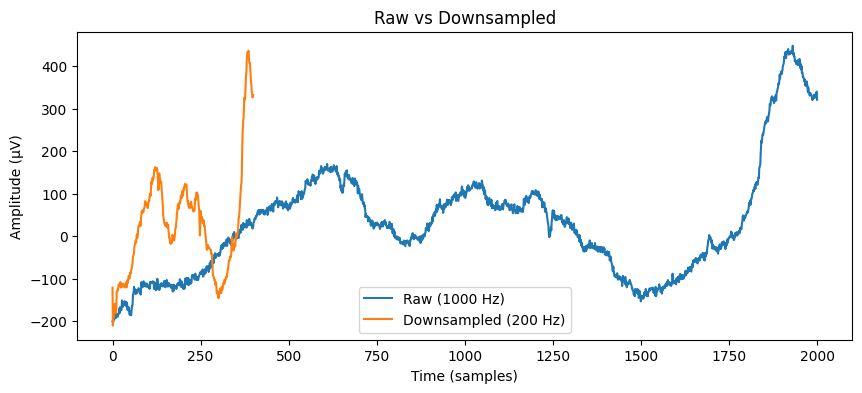

In [15]:
ch = 10
plt.figure(figsize=(10,4))
plt.plot(raw[ch, :2000], label="Raw (1000 Hz)")
plt.plot(data_ds[ch, :400], label="Downsampled (200 Hz)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.title("Raw vs Downsampled")
plt.show()


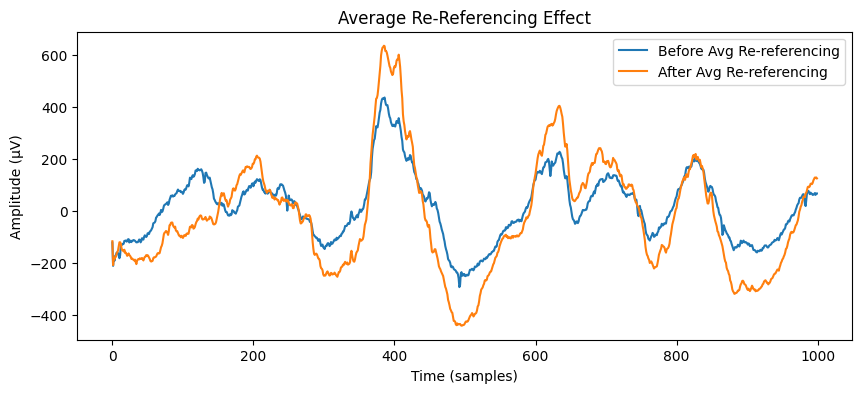

In [16]:
plt.figure(figsize=(10,4))
plt.plot(data_ds[ch, :1000], label="Before Avg Re-referencing")
plt.plot(data_ref[ch, :1000], label="After Avg Re-referencing")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.title("Average Re-Referencing Effect")
plt.show()


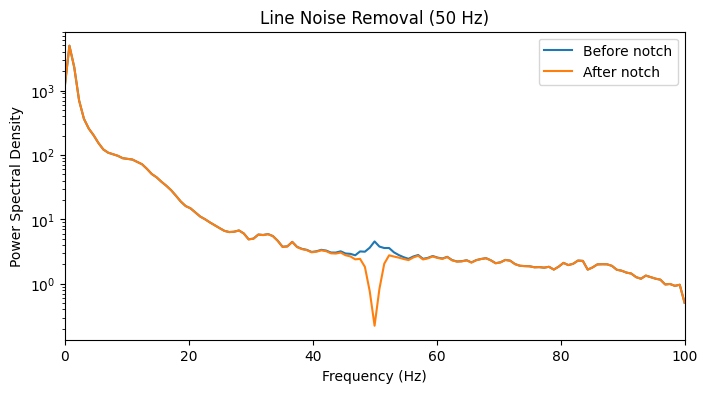

In [17]:
f1, P1 = welch(data_ref[ch], fs=200)
f2, P2 = welch(data_filt[ch], fs=200)

plt.figure(figsize=(8,4))
plt.semilogy(f1, P1, label="Before notch")
plt.semilogy(f2, P2, label="After notch")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.xlim(0,100)
plt.legend()
plt.title("Line Noise Removal (50 Hz)")
plt.show()



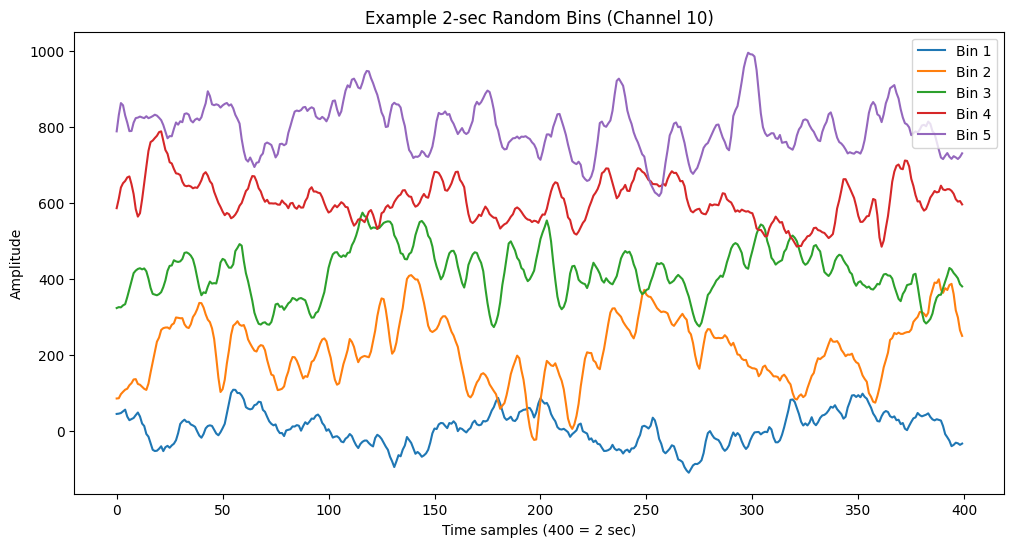

In [18]:
plt.figure(figsize=(12,6))

for i in range(5):
    plt.plot(all_selected_bins[i][10] + i*200, label=f"Bin {i+1}")

plt.title("Example 2-sec Random Bins (Channel 10)")
plt.xlabel("Time samples (400 = 2 sec)")
plt.legend()
plt.ylabel("Amplitude")
plt.show()


In [26]:
print("Session-wise bins selected:")
print("Session-1:", 20)
print("Session-2:", 20)
print("Session-3:", 20)
print("Total:", len(all_selected_bins))


Session-wise bins selected:
Session-1: 20
Session-2: 20
Session-3: 20
Total: 60


# Now addin the bipolar persepective where we have to select pair such that each electrode and electrode pair is used ONLY ONCE...

In [ ]:
def bipolar_reference_unique(data):
    # data shape: (128, T)
    bipolar_signals = []
    pairs = []

    # using ch1-ch2, ch3-ch4, ch5-ch6... scheme
    for ch in range(0, data.shape[0], 2):
        sig = data[ch] - data[ch+1]
        bipolar_signals.append(sig)
        pairs.append((ch+1, ch+2))

    bipolar_data = np.vstack(bipolar_signals)  # shape (64, T)
    return bipolar_data, pairs

bipolar_data, pairs = bipolar_reference_unique(data_filt)

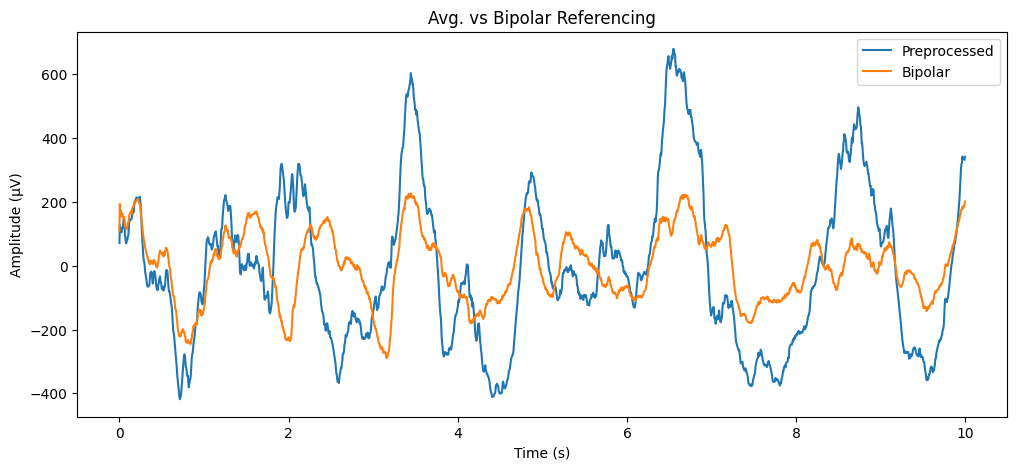

In [25]:
ch = 0 
t = np.arange(2000) / 200  # small window

plt.figure(figsize=(12,5))
plt.plot(t, data_filt[ch, :2000], label="Preprocessed")
plt.plot(t, bipolar_data[0, :2000], label="Bipolar")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("Avg. vs Bipolar Referencing")
plt.show()


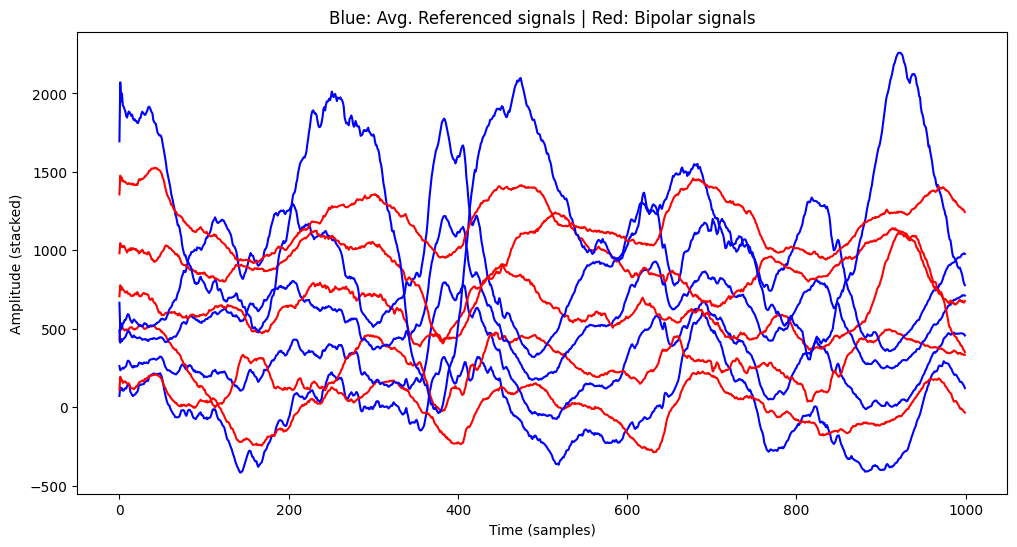

In [24]:
plt.figure(figsize=(12,6))

for i in range(5):
    plt.plot(data_filt[i, :1000] + i*300, color='blue')
    plt.plot(bipolar_data[i, :1000] + i*300, color='red')

plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (stacked)")
plt.title("Blue: Avg. Referenced signals | Red: Bipolar signals")
plt.show()
